# Bug triage with Deep Learning

In [1]:
import keras
from tensorflow.contrib.tensorboard.plugins import projector

C:\Users\Thiago\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from __future__ import print_function, division

In [3]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [4]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.initializers import TruncatedNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import optimizers

In [5]:
from methods.baseline import Baseline

## Auxiliary methods

## Dataset bugs

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

## Configurações Globais

In [6]:
MAX_SEQUENCE_LENGTH_T = 100 # 40
MAX_SEQUENCE_LENGTH_D = 100 # 200
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000

### Parse bugs preproprecessed

In [7]:
DIR = 'data/processed/eclipse'
DIR_PAIRS = 'data/normalized/eclipse'

In [8]:
df_train_pair = pd.read_csv(os.path.join(DIR_PAIRS, 'eclipse_pairs.csv'))
baseline = Baseline(DIR, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

In [9]:
baseline.load_ids(DIR)

In [10]:
len(baseline.bug_ids)

212512

### Dicionário de títulos e descrições

In [11]:
%%time

baseline.load_preprocess()

100%|█████████████████████████████████| 212512/212512 [19:15<00:00, 183.86it/s]


Wall time: 19min 15s


In [12]:
len(baseline.sentence_dict)

242718

## Geração de batches

### Generating tiple of batches

In [13]:
%%time

bug_dir = os.path.join(DIR)
baseline.prepare_dataset(bug_dir)

Reading train data
Wall time: 1.17 s


In [14]:
baseline.load_bugs()

100%|█████████████████████████████████| 212512/212512 [04:58<00:00, 711.91it/s]


In [15]:
%%time

batch_size = 512
batch_size_test = 512

# we want a constant validation group to have a frame of reference for model performance
train_gen = baseline.siam_gen(bug_dir, batch_size, 1)
valid_input_sample, valid_input_pos, valid_input_neg, valid_sim = baseline.batch_iterator(bug_dir, batch_size_test, 1)
test_gen = ([valid_input_sample['title'], valid_input_pos['title'], valid_input_neg['title'], 
             valid_input_sample['description'], valid_input_pos['description'], valid_input_neg['description']], valid_sim)

Wall time: 148 ms


In [16]:
valid_input_sample['title'].shape, valid_input_sample['description'].shape, valid_sim.shape

((512, 100), (512, 100), (512,))

### Validar entrada

In [17]:
%%time 

baseline.display_batch(bug_dir, 5)

Title: 
following 
Title: 
the restor
Description: 
following exception occurs while creating a new task to a trac repository right after pressing the create new button of the trac task editor org eclipse swt swtexception invalid thread access at org eclipse swt swt error swt java number at org eclipse swt swt error swt java number at org eclipse swt swt error swt java number at org eclipse swt widgets widget error widget java number at org eclipse swt widgets widget check widget widget java number at org eclipse swt custom ccombo get selection index ccombo java number at org eclipse mylar internal tasks ui editors abstract new repository task editor get category abstract new repository task editor java number at org eclipse mylar internal trac ui editor new trac task editor access number new trac task editor java number at org eclipse mylar internal trac ui editor new trac task editor number run new trac task editor java number at org eclipse core internal jobs worker run worker java 

build inumber the delete key has no effect in text fields in any dialogs i ve seen this in the cvs commit comment prompt the password prompt and the refactor rename prompt
Description: 
number mnu
similar = 0
########################
Title: 
test cases
Title: 
i get this
Description: 
test cases need to be ported to junit v number from current v number additionally it should be specified whether a test is client side or server side each test must have its specific text xml file with defined test classes conforming to the releng standard
Description: 
i get this
similar = 0
########################
Wall time: 191 ms


## Pre-trained embeddings

Loading pretrained word vectors

### Glove

In [18]:
%%time

baseline.generating_embed(GLOVE_DIR='data/embed', EMBEDDING_DIM=EMBEDDING_DIM, MAX_NB_WORDS=MAX_NB_WORDS)

1917494it [07:52, 4056.51it/s] 


Total 1917494 word vectors in Glove 42B 300d.
Found 154042 unique tokens.


100%|██████████████████████████████| 154042/154042 [00:00<00:00, 328915.37it/s]


Wall time: 10min 8s


## Towards Accurate Duplicate Bug Retrieval Using Deep Learning Techniques

https://github.com/tqtg/DuplicateBugFinder

### CNN with filter 3,4,5

In [19]:
import keras
from keras.layers import GlobalMaxPooling1D 

keras.backend.clear_session()

def cnn_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):

  embedding_layer = Embedding(num_words,
                              embedding_dim,
                              weights=[embeddings],
                              input_length=max_sequence_length,
                              trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length,), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

  # Yoon Kim model (https://arxiv.org/abs/1408.5882)
  convs = []
  filter_sizes = [3,4,5]

  for filter_size in filter_sizes:
      l_conv = Conv1D(filters=32, kernel_size=filter_size, activation='relu')(embedded_sequences)
      l_pool = MaxPooling1D(pool_size=3)(l_conv)
      convs.append(l_pool)

  # l_merge = Merge(mode='concat', concat_axis=1)(convs)

  l_merge = Concatenate(axis=1)(convs)

  # add a 1D convnet with global maxpooling, instead of Yoon Kim model
  conv = Conv1D(filters=64, kernel_size=3, activation='relu')(l_merge)
  layer = GlobalMaxPooling1D()(conv) # pool_size=3
  # Original Yoon Kim model
  #x = Flatten()(pool)
  #x = Dropout(0.5)(x)
  #layer = Activation('relu')(pool)

  cnn_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureCNNGenerationModel') # inputs=visible
  
  return cnn_feature_model

### Bi-LSTM

In [20]:
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional

def lstm_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):
  number_lstm_units = 100
  rate_drop_lstm = 0
  recurrent_dropout = 0

  embedding_layer = Embedding(num_words,
                          embedding_dim,
                          weights=[embeddings],
                          input_length=max_sequence_length,
                          trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length, ), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

   # Creating LSTM Encoder
  lstm_layer = Bidirectional(LSTM(number_lstm_units, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm), merge_mode='sum')

  layer = lstm_layer(embedded_sequences)

  #layer = Activation('relu')(x)

  lstm_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureLstmGenerationModel') # inputs=visible
  
  return lstm_feature_model

### Siamese model

In [21]:
from keras import backend as K
import tensorflow as tf

def l2_normalize(x, axis):
    norm = K.sqrt(K.sum(K.square(x), axis=axis, keepdims=True))
    return K.maximum(x, K.epsilon()) / K.maximum(norm, K.epsilon())

# https://github.com/keras-team/keras/issues/3031
# https://github.com/keras-team/keras/issues/8335
def cosine_distance(inputs):
    x, y = inputs
    x = l2_normalize(x, axis=-1)
    y = l2_normalize(y, axis=-1)
    similarity = K.batch_dot(x, y, axes=1)
    distance = K.constant(1) - similarity
    # Distance goes from 0 to 2 in theory, but from 0 to 1 if x and y are both
    # positive (which is the case after ReLU activation).
    return K.mean(distance, axis=-1)

def margin_loss(y_true, y_pred):
    margin = K.constant(1.0)
    return K.mean(K.maximum(0.0, margin - y_pred[0] + y_pred[1]))

def pos_distance(y_true, y_pred):
    return K.mean(y_pred[0])

def neg_distance(y_true, y_pred):
    return K.mean(y_pred[1])

def stack_tensors(vects):
    return K.squeeze(K.stack(vects),axis=1) # stack adds a new dim. So squeeze it
    # better method is to use concatenate
    return K.concatenate(vects,axis=1)

In [22]:
from keras.layers import concatenate, Add, Lambda, merge
from keras.optimizers import Adam

def siamese_model(lstm_feature_model, cnn_feature_model, max_sequence_length_t, max_sequence_length_d):
  
    bug_t_in = Input(shape = (max_sequence_length_t, ), name = 'title_in')
    bug_t_pos = Input(shape = (max_sequence_length_t, ), name = 'title_pos')
    bug_t_neg = Input(shape = (max_sequence_length_t, ), name = 'title_neg')

    bug_d_in = Input(shape = (max_sequence_length_d, ), name = 'desc_in')
    bug_d_pos = Input(shape = (max_sequence_length_d, ), name = 'desc_pos')
    bug_d_neg = Input(shape = (max_sequence_length_d, ), name = 'desc_neg')

    bug_t_in_feat_lstm = lstm_feature_model(bug_t_in)
    bug_t_pos_feat_lstm = lstm_feature_model(bug_t_pos)
    bug_t_neg_feat_lstm = lstm_feature_model(bug_t_neg)

    bug_d_in_feat_cnn = cnn_feature_model(bug_d_in)
    bug_d_pos_feat_cnn = cnn_feature_model(bug_d_pos)
    bug_d_neg_feat_cnn = cnn_feature_model(bug_d_neg)

    encoded_anchor = concatenate([bug_t_in_feat_lstm, bug_d_in_feat_cnn], name = 'merge_features_in')
    encoded_positive = concatenate([bug_t_pos_feat_lstm, bug_d_pos_feat_cnn], name = 'merge_features_pos')
    encoded_negative = concatenate([bug_t_neg_feat_lstm, bug_d_neg_feat_cnn], name = 'merge_features_neg')

    positive_d = Lambda(cosine_distance)([encoded_anchor, encoded_positive])
    negative_d = Lambda(cosine_distance)([encoded_anchor, encoded_negative])
    
    # Loss function only works with a single output
    output = Lambda(
        lambda vects: K.stack(vects),
        name='stack-distances',
    )([positive_d, negative_d])
  
    similarity_model = Model(inputs = [bug_t_in, bug_t_pos, bug_t_neg, bug_d_in, bug_d_pos, bug_d_neg], 
                           outputs = output, name = 'Similarity_Model')

    # setup the optimization process 
    similarity_model.compile(optimizer='adam', loss=margin_loss, metrics=[pos_distance, neg_distance]) # 'categorical_crossentropy' 

    return similarity_model

## Experiment

In [ ]:
%%time
import keras

# Inspired on https://pastebin.com/TaGFdcBA
# TODO: https://stackoverflow.com/questions/49941903/keras-compute-cosine-distance-between-two-flattened-outputs
keras.backend.clear_session()

cnn_feature_model = cnn_model(embeddings=baseline.embedding_matrix, 
                              num_words=len(baseline.word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_D, 
                              trainable=False)

lstm_feature_model = lstm_model(embeddings=baseline.embedding_matrix, 
                              num_words=len(baseline.word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_T, 
                              trainable=False)

similarity_model = siamese_model(lstm_feature_model, cnn_feature_model, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

# cnn_feature_model.summary()
# lstm_feature_model.summary()
similarity_model.summary()

tbCallBack = keras.callbacks.TensorBoard(log_dir='logs/training', histogram_freq=0, write_graph=True, write_images=True)

h = similarity_model.fit_generator(train_gen, 
                               steps_per_epoch = 10,
                               #validation_data=test_gen, # 
                                             epochs = 1000,
                                             verbose = True,
                                               callbacks=[tbCallBack]
                                              )  # 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_in (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
desc_in (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
title_pos (InputLayer)          (None, 100)          0                                            
__________________________________________________________________________________________________
desc_pos (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
title_neg 

10/10 [==============================] - ETA: 3:17 - loss: 0.9720 - pos_distance: 0.3691 - neg_distance: 0.341 - ETA: 2:56 - loss: 0.9692 - pos_distance: 0.3544 - neg_distance: 0.323 - ETA: 2:38 - loss: 0.9666 - pos_distance: 0.3561 - neg_distance: 0.322 - ETA: 2:18 - loss: 0.9654 - pos_distance: 0.3642 - neg_distance: 0.329 - ETA: 1:55 - loss: 0.9678 - pos_distance: 0.3840 - neg_distance: 0.351 - ETA: 1:32 - loss: 0.9683 - pos_distance: 0.3912 - neg_distance: 0.359 - ETA: 1:09 - loss: 0.9684 - pos_distance: 0.3856 - neg_distance: 0.354 - ETA: 46s - loss: 0.9659 - pos_distance: 0.3731 - neg_distance: 0.338 - ETA: 23s - loss: 0.9636 - pos_distance: 0.3757 - neg_distance: 0.33 - 237s 24s/step - loss: 0.9627 - pos_distance: 0.3891 - neg_distance: 0.3518
Epoch 7/1000
10/10 [==============================] - ETA: 3:55 - loss: 0.9725 - pos_distance: 0.5352 - neg_distance: 0.507 - ETA: 3:33 - loss: 0.9765 - pos_distance: 0.5206 - neg_distance: 0.497 - ETA: 3:04 - loss: 0.9739 - pos_distance: 

10/10 [==============================] - ETA: 4:14 - loss: 0.9643 - pos_distance: 0.3902 - neg_distance: 0.354 - ETA: 3:56 - loss: 0.9589 - pos_distance: 0.3974 - neg_distance: 0.356 - ETA: 3:27 - loss: 0.9598 - pos_distance: 0.4028 - neg_distance: 0.362 - ETA: 2:57 - loss: 0.9545 - pos_distance: 0.4052 - neg_distance: 0.359 - ETA: 2:27 - loss: 0.9562 - pos_distance: 0.3995 - neg_distance: 0.355 - ETA: 1:57 - loss: 0.9574 - pos_distance: 0.3918 - neg_distance: 0.349 - ETA: 1:27 - loss: 0.9570 - pos_distance: 0.3949 - neg_distance: 0.351 - ETA: 58s - loss: 0.9553 - pos_distance: 0.4038 - neg_distance: 0.359 - ETA: 29s - loss: 0.9543 - pos_distance: 0.4101 - neg_distance: 0.36 - 292s 29s/step - loss: 0.9553 - pos_distance: 0.4108 - neg_distance: 0.3662
Epoch 17/1000
10/10 [==============================] - ETA: 5:53 - loss: 0.9415 - pos_distance: 0.3570 - neg_distance: 0.298 - ETA: 4:35 - loss: 0.9517 - pos_distance: 0.3490 - neg_distance: 0.300 - ETA: 3:47 - loss: 0.9498 - pos_distance:

10/10 [==============================] - ETA: 5:00 - loss: 0.9457 - pos_distance: 0.5668 - neg_distance: 0.512 - ETA: 4:30 - loss: 0.9606 - pos_distance: 0.5655 - neg_distance: 0.526 - ETA: 3:42 - loss: 0.9644 - pos_distance: 0.5526 - neg_distance: 0.517 - ETA: 3:07 - loss: 0.9534 - pos_distance: 0.5371 - neg_distance: 0.490 - ETA: 2:37 - loss: 0.9533 - pos_distance: 0.5283 - neg_distance: 0.481 - ETA: 2:05 - loss: 0.9530 - pos_distance: 0.5137 - neg_distance: 0.466 - ETA: 1:33 - loss: 0.9513 - pos_distance: 0.5054 - neg_distance: 0.456 - ETA: 1:02 - loss: 0.9522 - pos_distance: 0.5031 - neg_distance: 0.455 - ETA: 31s - loss: 0.9511 - pos_distance: 0.4965 - neg_distance: 0.447 - 310s 31s/step - loss: 0.9499 - pos_distance: 0.4950 - neg_distance: 0.4449
Epoch 27/1000
10/10 [==============================] - ETA: 4:42 - loss: 0.9616 - pos_distance: 0.4767 - neg_distance: 0.438 - ETA: 4:13 - loss: 0.9671 - pos_distance: 0.5066 - neg_distance: 0.473 - ETA: 3:38 - loss: 0.9589 - pos_distanc

10/10 [==============================] - ETA: 4:45 - loss: 0.9239 - pos_distance: 0.5626 - neg_distance: 0.486 - ETA: 4:14 - loss: 0.9379 - pos_distance: 0.5772 - neg_distance: 0.515 - ETA: 3:40 - loss: 0.9423 - pos_distance: 0.5611 - neg_distance: 0.503 - ETA: 3:08 - loss: 0.9457 - pos_distance: 0.5201 - neg_distance: 0.465 - ETA: 2:36 - loss: 0.9448 - pos_distance: 0.4846 - neg_distance: 0.429 - ETA: 2:04 - loss: 0.9436 - pos_distance: 0.4618 - neg_distance: 0.405 - ETA: 1:33 - loss: 0.9480 - pos_distance: 0.4435 - neg_distance: 0.391 - ETA: 1:02 - loss: 0.9488 - pos_distance: 0.4352 - neg_distance: 0.384 - ETA: 31s - loss: 0.9489 - pos_distance: 0.4324 - neg_distance: 0.381 - 310s 31s/step - loss: 0.9481 - pos_distance: 0.4342 - neg_distance: 0.3824
Epoch 37/1000
10/10 [==============================] - ETA: 4:43 - loss: 0.9404 - pos_distance: 0.5006 - neg_distance: 0.441 - ETA: 4:17 - loss: 0.9515 - pos_distance: 0.4894 - neg_distance: 0.440 - ETA: 3:44 - loss: 0.9536 - pos_distanc

10/10 [==============================] - ETA: 4:22 - loss: 0.9113 - pos_distance: 0.5322 - neg_distance: 0.443 - ETA: 3:52 - loss: 0.9252 - pos_distance: 0.5335 - neg_distance: 0.458 - ETA: 3:24 - loss: 0.9297 - pos_distance: 0.5156 - neg_distance: 0.445 - ETA: 2:54 - loss: 0.9255 - pos_distance: 0.5036 - neg_distance: 0.429 - ETA: 2:25 - loss: 0.9254 - pos_distance: 0.5213 - neg_distance: 0.446 - ETA: 1:55 - loss: 0.9281 - pos_distance: 0.5314 - neg_distance: 0.459 - ETA: 1:26 - loss: 0.9318 - pos_distance: 0.5258 - neg_distance: 0.457 - ETA: 57s - loss: 0.9335 - pos_distance: 0.5107 - neg_distance: 0.444 - ETA: 29s - loss: 0.9374 - pos_distance: 0.4928 - neg_distance: 0.43 - 290s 29s/step - loss: 0.9388 - pos_distance: 0.4842 - neg_distance: 0.4231
Epoch 47/1000
10/10 [==============================] - ETA: 4:32 - loss: 0.9528 - pos_distance: 0.5318 - neg_distance: 0.484 - ETA: 3:57 - loss: 0.9429 - pos_distance: 0.5552 - neg_distance: 0.498 - ETA: 3:27 - loss: 0.9388 - pos_distance:

10/10 [==============================] - ETA: 4:14 - loss: 0.9232 - pos_distance: 0.4026 - neg_distance: 0.325 - ETA: 3:49 - loss: 0.9223 - pos_distance: 0.4332 - neg_distance: 0.355 - ETA: 3:20 - loss: 0.9224 - pos_distance: 0.4579 - neg_distance: 0.380 - ETA: 2:51 - loss: 0.9205 - pos_distance: 0.4706 - neg_distance: 0.391 - ETA: 2:23 - loss: 0.9201 - pos_distance: 0.4621 - neg_distance: 0.382 - ETA: 1:56 - loss: 0.9227 - pos_distance: 0.4562 - neg_distance: 0.378 - ETA: 1:27 - loss: 0.9270 - pos_distance: 0.4736 - neg_distance: 0.400 - ETA: 58s - loss: 0.9267 - pos_distance: 0.4915 - neg_distance: 0.418 - ETA: 29s - loss: 0.9249 - pos_distance: 0.4927 - neg_distance: 0.41 - 293s 29s/step - loss: 0.9257 - pos_distance: 0.4863 - neg_distance: 0.4120
Epoch 57/1000
10/10 [==============================] - ETA: 4:25 - loss: 0.9229 - pos_distance: 0.4215 - neg_distance: 0.344 - ETA: 3:54 - loss: 0.9230 - pos_distance: 0.4128 - neg_distance: 0.335 - ETA: 3:36 - loss: 0.9312 - pos_distance:

10/10 [==============================] - ETA: 4:18 - loss: 0.9019 - pos_distance: 0.4868 - neg_distance: 0.388 - ETA: 3:54 - loss: 0.9086 - pos_distance: 0.4492 - neg_distance: 0.357 - ETA: 3:26 - loss: 0.9187 - pos_distance: 0.4755 - neg_distance: 0.394 - ETA: 2:55 - loss: 0.9180 - pos_distance: 0.4960 - neg_distance: 0.414 - ETA: 2:28 - loss: 0.9178 - pos_distance: 0.4980 - neg_distance: 0.415 - ETA: 1:58 - loss: 0.9167 - pos_distance: 0.4922 - neg_distance: 0.408 - ETA: 1:28 - loss: 0.9185 - pos_distance: 0.4714 - neg_distance: 0.390 - ETA: 59s - loss: 0.9196 - pos_distance: 0.4593 - neg_distance: 0.378 - ETA: 29s - loss: 0.9177 - pos_distance: 0.4760 - neg_distance: 0.39 - 294s 29s/step - loss: 0.9194 - pos_distance: 0.4871 - neg_distance: 0.4065
Epoch 67/1000
10/10 [==============================] - ETA: 4:29 - loss: 0.9069 - pos_distance: 0.5291 - neg_distance: 0.435 - ETA: 49:43:33 - loss: 0.9062 - pos_distance: 0.4598 - neg_distance: 0.366 - ETA: 29:01:38 - loss: 0.9118 - pos_d

10/10 [==============================] - ETA: 5:11 - loss: 0.9098 - pos_distance: 0.4403 - neg_distance: 0.350 - ETA: 4:42 - loss: 0.9168 - pos_distance: 0.4484 - neg_distance: 0.365 - ETA: 4:07 - loss: 0.9110 - pos_distance: 0.4695 - neg_distance: 0.380 - ETA: 3:31 - loss: 0.9079 - pos_distance: 0.4849 - neg_distance: 0.392 - ETA: 2:52 - loss: 0.9086 - pos_distance: 0.4845 - neg_distance: 0.393 - ETA: 2:16 - loss: 0.9136 - pos_distance: 0.4848 - neg_distance: 0.398 - ETA: 1:41 - loss: 0.9101 - pos_distance: 0.4851 - neg_distance: 0.395 - ETA: 1:08 - loss: 0.9112 - pos_distance: 0.4782 - neg_distance: 0.389 - ETA: 34s - loss: 0.9104 - pos_distance: 0.4741 - neg_distance: 0.384 - 347s 35s/step - loss: 0.9093 - pos_distance: 0.4755 - neg_distance: 0.3848
Epoch 77/1000
10/10 [==============================] - ETA: 5:18 - loss: 0.9194 - pos_distance: 0.5305 - neg_distance: 0.449 - ETA: 4:43 - loss: 0.9077 - pos_distance: 0.5114 - neg_distance: 0.419 - ETA: 4:07 - loss: 0.9094 - pos_distanc

10/10 [==============================] - ETA: 4:42 - loss: 0.9263 - pos_distance: 0.4408 - neg_distance: 0.367 - ETA: 4:14 - loss: 0.9173 - pos_distance: 0.4255 - neg_distance: 0.342 - ETA: 3:44 - loss: 0.9135 - pos_distance: 0.4248 - neg_distance: 0.338 - ETA: 3:11 - loss: 0.9153 - pos_distance: 0.4327 - neg_distance: 0.348 - ETA: 2:37 - loss: 0.9150 - pos_distance: 0.4407 - neg_distance: 0.355 - ETA: 2:05 - loss: 0.9157 - pos_distance: 0.4495 - neg_distance: 0.365 - ETA: 1:33 - loss: 0.9171 - pos_distance: 0.4467 - neg_distance: 0.363 - ETA: 1:02 - loss: 0.9190 - pos_distance: 0.4409 - neg_distance: 0.359 - ETA: 31s - loss: 0.9162 - pos_distance: 0.4387 - neg_distance: 0.354 - 310s 31s/step - loss: 0.9164 - pos_distance: 0.4429 - neg_distance: 0.3593
Epoch 87/1000
10/10 [==============================] - ETA: 4:37 - loss: 0.9049 - pos_distance: 0.5945 - neg_distance: 0.499 - ETA: 4:09 - loss: 0.9173 - pos_distance: 0.6022 - neg_distance: 0.519 - ETA: 3:35 - loss: 0.9140 - pos_distanc

10/10 [==============================] - ETA: 4:17 - loss: 0.9116 - pos_distance: 0.6095 - neg_distance: 0.521 - ETA: 3:54 - loss: 0.9317 - pos_distance: 0.6366 - neg_distance: 0.568 - ETA: 3:34 - loss: 0.9253 - pos_distance: 0.6517 - neg_distance: 0.577 - ETA: 3:01 - loss: 0.9175 - pos_distance: 0.6341 - neg_distance: 0.551 - ETA: 2:30 - loss: 0.9183 - pos_distance: 0.5959 - neg_distance: 0.514 - ETA: 2:00 - loss: 0.9187 - pos_distance: 0.5497 - neg_distance: 0.468 - ETA: 1:29 - loss: 0.9203 - pos_distance: 0.5237 - neg_distance: 0.444 - ETA: 59s - loss: 0.9168 - pos_distance: 0.5188 - neg_distance: 0.435 - ETA: 29s - loss: 0.9178 - pos_distance: 0.5365 - neg_distance: 0.45 - 294s 29s/step - loss: 0.9170 - pos_distance: 0.5480 - neg_distance: 0.4649
Epoch 97/1000
10/10 [==============================] - ETA: 4:19 - loss: 0.9144 - pos_distance: 0.5779 - neg_distance: 0.492 - ETA: 4:21 - loss: 0.9091 - pos_distance: 0.5442 - neg_distance: 0.453 - ETA: 3:38 - loss: 0.9120 - pos_distance:

10/10 [==============================] - ETA: 4:20 - loss: 0.9047 - pos_distance: 0.4450 - neg_distance: 0.349 - ETA: 4:11 - loss: 0.9061 - pos_distance: 0.3817 - neg_distance: 0.287 - ETA: 3:31 - loss: 0.9115 - pos_distance: 0.3476 - neg_distance: 0.259 - ETA: 3:11 - loss: 0.9108 - pos_distance: 0.3651 - neg_distance: 0.275 - ETA: 2:33 - loss: 0.9119 - pos_distance: 0.4049 - neg_distance: 0.316 - ETA: 2:00 - loss: 0.9092 - pos_distance: 0.4552 - neg_distance: 0.364 - ETA: 1:29 - loss: 0.9109 - pos_distance: 0.4817 - neg_distance: 0.392 - ETA: 59s - loss: 0.9089 - pos_distance: 0.4938 - neg_distance: 0.402 - ETA: 29s - loss: 0.9083 - pos_distance: 0.4883 - neg_distance: 0.39 - 292s 29s/step - loss: 0.9077 - pos_distance: 0.4759 - neg_distance: 0.3837
Epoch 107/1000
10/10 [==============================] - ETA: 5:24 - loss: 0.9228 - pos_distance: 0.3712 - neg_distance: 0.294 - ETA: 4:12 - loss: 0.9134 - pos_distance: 0.3928 - neg_distance: 0.306 - ETA: 3:54 - loss: 0.9104 - pos_distance

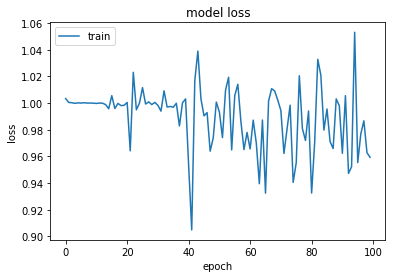

In [132]:
loss=h.history['loss']

plt.plot(loss, label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

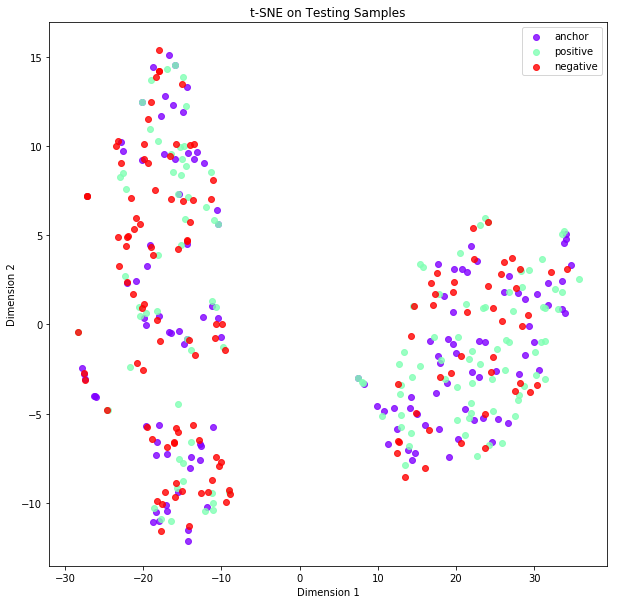

Wall time: 17 s


In [133]:
%%time

baseline.display_embed_space(similarity_model, 128)

In [ ]:
name = 'baseline_1000epoch_10steps_512batch(eclipse)'
Baseline.save_model('', similarity_model, name)
Baseline.save_result('', h, name)

In [ ]:
name = 'baseline_1000epoch_10steps_512batch(eclipse)'
Baseline.load_model('', name)

## Classification

In [ ]:
for layer in similarity_model.layers:
    print(layer.name)

In [ ]:
## Freeze weights
for layer in similarity_model.layers:
    layer.trainable = False
    

bug_t_a = Input(shape = (max_sequence_length_t, ), name = 'title_a')
bug_t_b = Input(shape = (max_sequence_length_t, ), name = 'title_b')

bug_d_a = Input(shape = (max_sequence_length_d, ), name = 'desc_a')
bug_d_b = Input(shape = (max_sequence_length_d, ), name = 'desc_b')
    
# Model 1
model = similarity_model.get_layer('merge_features_in')

bugt_t_a = model(bug_t_a)
bugt_d_a = model(bug_d_a)

bugt_t_b = model(bug_t_b)
bugt_d_b = model(bug_d_b)

bug_a = concatenate([bugt_t_a, bugt_d_a], name = 'bug_a')
bug_b = concatenate([bugt_t_b, bugt_d_b], name = 'bug_b')

x = Concatenate()([x_in, x_pos])
x = Dense(64, activation = 'relu')(x)
#x = Dense(32, activation = 'relu')(x)
output = Dense(2, activation = 'softmax', name = 'output')(x)

model_clf = Model(inputs=similarity_model.input, outputs=[output])
model_clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model_clf.summary()

In [ ]:
%%time

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

valid_labels = encoder.fit_transform(test_gen[1])
valid_labels = to_categorical(valid_labels)
test_validation = (test_gen[0], valid_labels)

h_clf = model_clf.fit_generator(baseline.siam_gen_classification(bug_dir, 512, 1), 
                               steps_per_epoch = 16,
                               validation_data=test_validation, # 
                                             epochs = 100,
                                             verbose = True) # callbacks=[early]

In [ ]:
Baseline.validation_accuracy_loss(h_clf)

In [ ]:
name = 'baseline_classification_100epoch_16steps(eclipse)'
save_model(similarity_model, name)
save_result(h, name)